In [2]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
from PlotFuncs import *
from LabFuncs import *
from Params import *
from HaloFuncs import *
from WIMPFuncs import *
from scipy.stats import norm
import pandas

# Load shards
df = pandas.read_csv('../data/FitShards.csv')
names = df.group_id
nshards = size(names)
velocities = zeros(shape=(nshards,3))
dispersions = zeros(shape=(nshards,3))
velocities[0:(nshards),0] = df.vx # stream velocities
velocities[0:(nshards),1] = df.vy
velocities[0:(nshards),2] = df.vz
dispersions[0:(nshards),0] = df.sigx # dispersion tensors
dispersions[0:(nshards),1] = df.sigy
dispersions[0:(nshards),2] = df.sigz
pops = df.population
Psun = df.Psun
weights = pops*(Psun<3.0)
weights /= sum(weights)

# Halo params
HaloModel = SHMpp
v0 = HaloModel.RotationSpeed
v_esc = HaloModel.EscapeSpeed
sig_beta = HaloModel.SausageDispersionTensor
sig_iso = array([1.0,1.0,1.0])*v0/sqrt(2.0)
day = 67.0 

from scipy.optimize import fmin


# FUNCTION MINIMISING METHOD 


def qhat(x):
    qhat = zeros(shape=(1,3))
    qhat[0,0] = sqrt(1-x[0]**2.0)*cos(x[1])
    qhat[0,1] = sqrt(1-x[0]**2.0)*sin(x[1])
    qhat[0,2] = x[0]
    return qhat


v_lab = LabVelocitySimple(day)
x_lab = -1.0*v_lab/sqrt(sum(v_lab**2.0))

m_chi = 20.0
sigma_p = 1.0e-45
A = F19.MassNumber

n_xi = 20
xi_vals = linspace(0,0.35,n_xi)




ne = 300
Evals = linspace(0.1,50.0,ne)
xmin0 = zeros(shape=(ne,2))
xmin_in = array([-0.05,4.4])
dth0 = zeros(shape=(ne))
for i in range(0,ne):
    v_min = MinimumWIMPSpeed(Evals[i],A,m_chi)
    def fhat0(x):
        return -1.0*fhat_Isotropic(v_min,qhat(x),day)
    if fhat0(xmin_in)==0.0:
        dth0[i] = 0.0
    else:
        res = fmin(fhat0,xmin_in,disp=False)
        xmin0[i,0] = res[0]
        xmin0[i,1] = res[1]
        xmin_in = xmin0[i,:]
        dth0[i] = 180/pi*arccos(sum(qhat(xmin_in)*x_lab))

xmin = zeros(shape=(ne,2,n_xi))
dth = zeros(shape=(ne,n_xi))
xmin_in = xmin0[0,:]
for j in range(0,n_xi):
    xi = xi_vals[j]
    for i in range(0,ne):
        if i==0:
            xmin_in = xmin0[i,:]
        else:
            xmin_in = xmin[i-1,:,j]
        
        v_min = MinimumWIMPSpeed(Evals[i],A,m_chi)
        def fhat(x):
            fhat = -1.0*(1-xi)*fhat_Isotropic(v_min,qhat(x),day)
            for k in range(0,nshards):
                v_s = velocities[k,:]
                sig_s = dispersions[k,:]
                fhat += -1.0*xi*weights[k]*fhat_Triaxial(v_min,qhat(x),day,sig_s,v_shift=v_s)
            return fhat
        if fhat(xmin_in)==0.0:
            dth[i,j] = 0.0
        else:
            res = fmin(fhat,xmin_in,disp=False)
            xmin[i,0,j] = res[0]
            xmin[i,1,j] = res[1]
            dth[i,j] = 180/pi*arccos(sum(qhat(xmin[i,:,j])*x_lab))
    print j,xi

0 0.0
1 0.0184210526316
2 0.0368421052632
3 0.0552631578947
4 0.0736842105263
5 0.0921052631579
6 0.110526315789
7 0.128947368421
8 0.147368421053
9 0.165789473684
10 0.184210526316
11 0.202631578947
12 0.221052631579
13 0.239473684211
14 0.257894736842
15 0.276315789474
16 0.294736842105
17 0.313157894737
18 0.331578947368
19 0.35


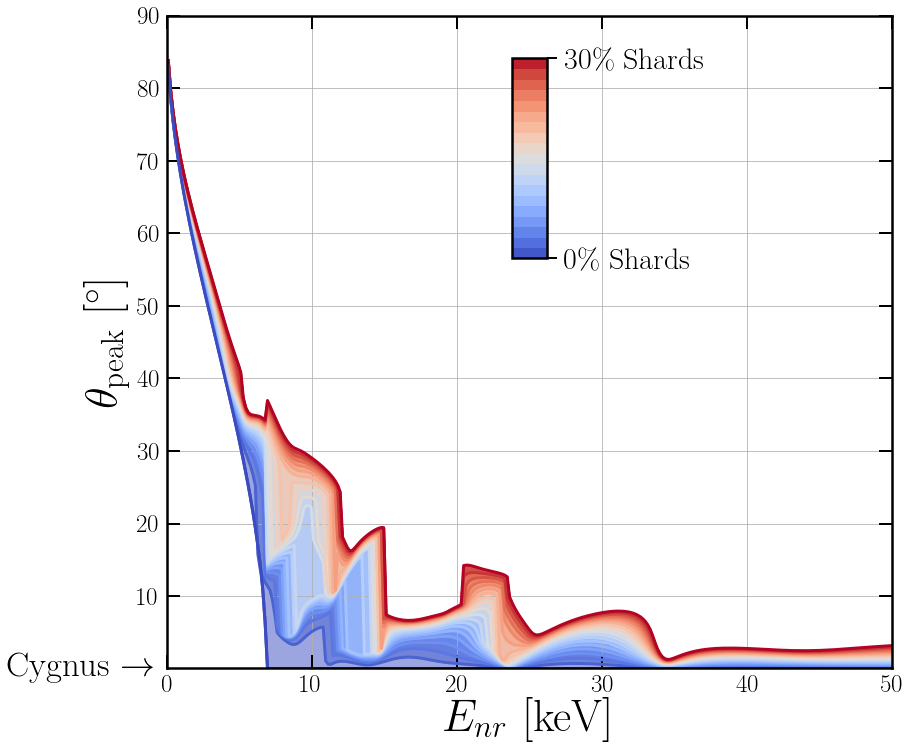

In [3]:
# Figure setup
pltname = 'Shards_peakdirection'

xlab = r"$E_{\rm nr}$ [keV]"
ylab = r"$\theta_{\rm peak}$ [$^\circ$]"
fig,ax = MySquarePlot(xlab,ylab)

col = (cm.coolwarm(linspace(0,1,n_xi)))
cmap = cm.coolwarm
for j in range(0,n_xi):
    plt.fill_between(Evals,dth[:,j],y2=dth[:,-1],color=col[j,:],alpha=0.5)
    plt.plot(Evals,dth[:,j],'-',color=col[j,:],linewidth=3)

plt.plot(Evals,dth0,linewidth=3,color=col[0,:])
plt.ylim([0.1,90])
plt.xlim([0,amax(Evals)])
plt.text(-11,-1,r'Cygnus $\rightarrow$',fontsize=35)
plt.grid()

# Custom colorbar
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbaxes = inset_axes(ax, width="5%", height="50%", bbox_to_anchor=[-190, 330, 700, 400]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,n_xi))
f = plt.gcf().get_children()
cbar = f[2]
cbar.set_yticklabels(['0\% Shards', '30\% Shards'])  # vertically oriented colorbar
cbar.tick_params(labelsize=30) 
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)


# Save figure
plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')